In [15]:
# !pip install numpy
# !pip install seaborn
# !pip install sklearn
# !pip install matplotlib

# Imports

In [16]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

METADATA_FILE_PATH = "census_income_metadata.txt"
TRAIN_FILE_PATH = "census_income_learn.csv"
TEST_FILE_PATH = "census_income_test.csv"
COLUMNS_PATH = "columns.json"

# Creation des dataframes de train et de test

J'ai mis dans le fichier *columns.json* les noms des différents paramètres et leurs valeurs respectives.

In [17]:
def load_columns(path):
    with open(path, 'r') as f:
        return json.load(f)

def save_json(path, data):
    with open(path, 'w') as f:
        json.dump(data, f, indent=4)

def get_continuous_columns(columns):
    res = []
    for key, value in columns.items():
        if key != "MARSUPWT" and value == ["continuous"]:
            res.append(key)
    return res

def get_categorical_columns(columns):
    res = []
    for key, value in columns.items():
        if value != ["continuous"]:
            res.append(key)
    return res

In [18]:
columns = load_columns(path=COLUMNS_PATH)
column_names = list(columns.keys()) + ["INCOME"]

# On supprime toutes les lignes comportant des NaN ou des '?'
train = pd.read_csv(TRAIN_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()
test = pd.read_csv(TEST_FILE_PATH, sep=', ', names=column_names, na_values=["?"], engine="python").dropna()

# On remplace la colonne à prédire par des valeurs binaires
train.INCOME = train.INCOME.replace(["- 50000.", "50000+."], [0, 1])
test.INCOME = test.INCOME.replace(["- 50000.", "50000+."], [0, 1])

# On drop la colonne "instance weight"
train.drop(["MARSUPWT"], axis=1, inplace=True)
test.drop(["MARSUPWT"], axis=1, inplace=True)
column_names.remove("MARSUPWT")
train.shape, test.shape

((94462, 41), (47082, 41))

In [19]:
# On supprime les colonnes contenant une seule valeur
for col in column_names:
    if len(train[col].unique()) == 1 or len(test[col].unique()) == 1:
        train.drop([col], axis=1, inplace=True)
        test.drop([col], axis=1, inplace=True)

In [20]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,INCOME
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,0
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,0


# Plot de quelques valeurs du dataset

Parmis les différentes observations que l'on peut faire ici, la plus importante est le déséquilibre entre les 2 classes à prédire. On retrouve en effet dans nos datasets de train et de test environ 95% de revenus inférieurs à 50 000 et 5% du reste.

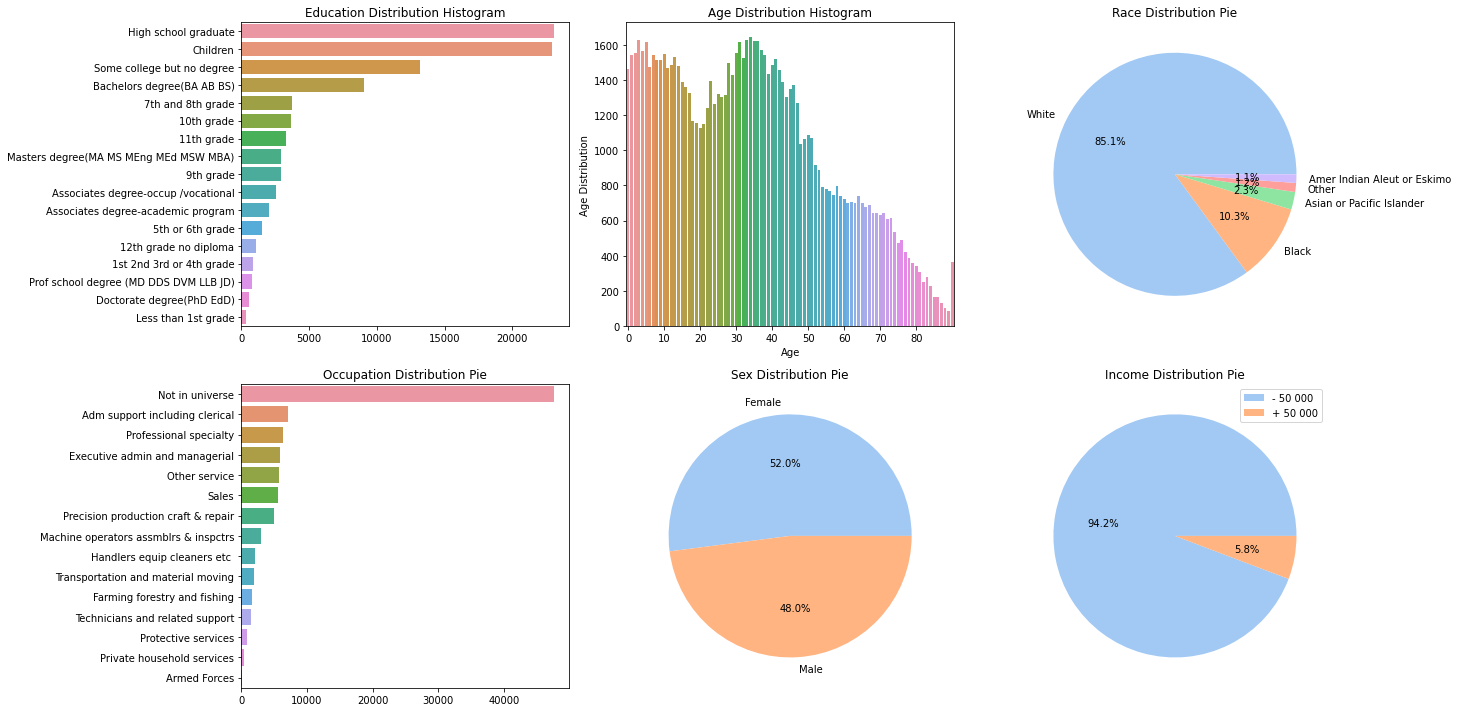

In [21]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette('pastel')

# Age distribution
ax = plt.subplot(232)
age_count = train.AAGE.value_counts()
sns.barplot(x=age_count.index, y=age_count.values)
min_tick, max_tick = np.min(age_count.index), np.max(age_count.index)
plt.xticks(range(min_tick, max_tick, 10))
ax.set_xlabel("Age")
ax.set_ylabel("Age Distribution")
ax.set_title("Age Distribution Histogram")

# Education Distribution
ax = plt.subplot(231)
education_count = train.AHGA.value_counts()
sns.barplot(x=education_count.values, y=education_count.index)
ax.set_title("Education Distribution Histogram")

# Race Distribution
ax = plt.subplot(233)
race_counts = train.ARACE.value_counts()
ax.pie(race_counts, labels=race_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Race Distribution Pie")

# Sex Distribution
ax = plt.subplot(235)
sex_counts = train.ASEX.value_counts()
ax.pie(sex_counts, labels=sex_counts.index, colors=colors, autopct='%.1f%%')
ax.set_title("Sex Distribution Pie")

# Occupation Distribution
ax = plt.subplot(234)
occupation_counts = train.AMJOCC.value_counts()
sns.barplot(x=occupation_counts.values, y=occupation_counts.index)
ax.set_title("Occupation Distribution Pie")

# Income Distribution
ax = plt.subplot(236)
income_counts = train.INCOME.value_counts()
ax.pie(income_counts, labels=income_counts.index, labeldistance=None, colors=colors, autopct='%.1f%%')
ax.set_title("Income Distribution Pie")
ax.legend(["- 50 000", "+ 50 000"])

plt.tight_layout()
plt.show()

# Plot des correlations

En affichant les correlations des valeurs numériques, on remarque quelques liens assez logiques dans notre dataset. On a par exemple des paramètres comme l'âge (AAGE) et les bénéfices attribués aux vétérans (VETYN) qui semblent étroitement liés, ou encore le type d'industrie (ADTIND) ainsi que le nombre de semaine de travail dans l'année (WKSWORK), etc...  
Même si ces liens peuvent sembler assez évidents, cette heatmap montre qu'ils sont tout de même présents dans le dataset. Ce dernier semble donc très représentatif de ce que l'on retrouve dans notre quotidien.

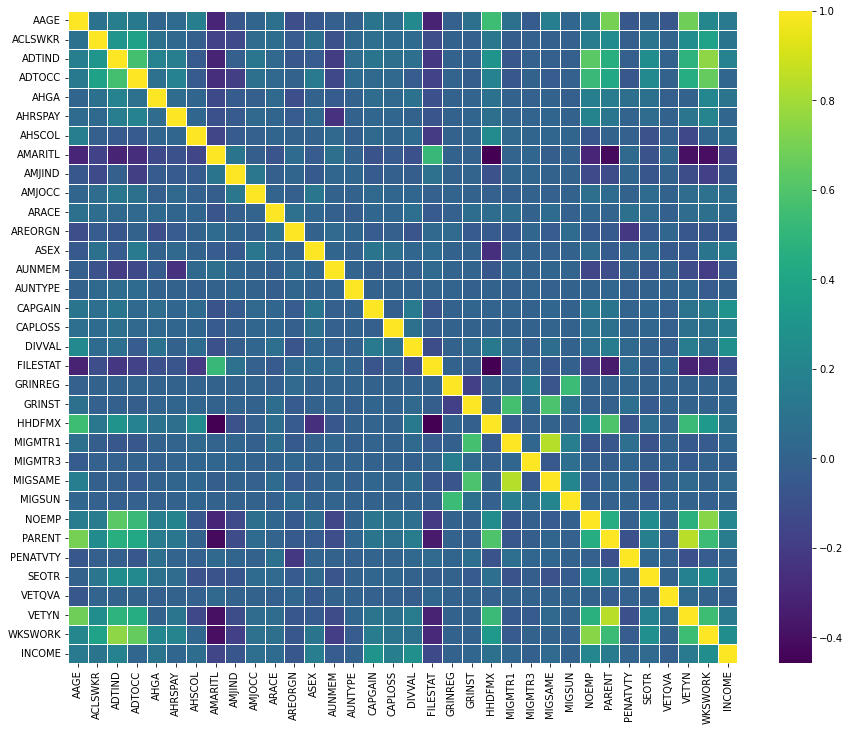

In [30]:
# On change les données représentées par des strings grâce au LabelEncoder sinon leurs correlations ne seront pas calculées
correlations = train.apply(LabelEncoder().fit_transform).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, linewidths=.8, cmap="viridis")
plt.show()

De plus grâce aux correlations, on se rend compte que certaines colonnes sont étroitement liées:
- les colonnes concernant les statistiques sur la famille (HHDFMX et HHDREL)
- les colonnes concernant les codes de migration (MIGMTR3 et MIGMTR4)
- les colonnes concernant les pays de naissances de la famille et la citoyenneté (PEFNTVTY, PEMNTVTY, PENATVTY et PRCITSHP)

Supprimer certaines de ces colonnes pour n'en garder qu'une par catégorie permet de réduire grandement la dimensionnalité sans pour autant perdre trop d'informations.

In [23]:
train.drop(["HHDREL", "MIGMTR4", "PEFNTVTY", "PEMNTVTY", "PRCITSHP"], axis=1, inplace=True)
test.drop(["HHDREL", "MIGMTR4", "PEFNTVTY", "PEMNTVTY", "PRCITSHP"], axis=1, inplace=True)

On peut également sortir de ce tableau de corrélation les paramètres les plus liés aux revenus. On observe ainsi que les gains (CAPGAIN), les dividendes des actions (DIVVAL) ou encore le nombre de semaines de travail par année (WKSWORK) influent grandement sur les revenus.

In [40]:
correlations.INCOME.sort_values(ascending=False).head(5)

INCOME     1.000000
CAPGAIN    0.288688
DIVVAL     0.266365
WKSWORK    0.252977
NOEMP      0.209274
Name: INCOME, dtype: float64

# Séparation du dataset entre les données et les labels

On va maintenant encoder les valeurs categorical de notre dataset grâce au *OneHotEncoder*. On pourrait à la place utiliser le *LabelEncoder*, cependant ce dernier insinue que les éléments sont reliés les uns aux autres ce qui n'est pas le cas ici.

In [24]:
train_X, train_y = train.iloc[:,0:-1], train.iloc[:,-1]
test_X, test_y = test.iloc[:,0:-1], test.iloc[:,-1]

dataset = pd.concat([train, test]).drop(["INCOME"], axis=1)
encoder = OneHotEncoder().fit(dataset)

train_X = encoder.transform(train_X).toarray()
test_X = encoder.transform(test_X).toarray()
train_X.shape, test_X.shape

((94462, 2864), (47082, 2864))

La PCA nous permettrait également de réduire la dimensionnalité globale de notre dataset, cependant il marche mieux sur des valeurs continues. On a a ici une majorité de valeurs categorical, l'utiliser ne sera donc pas d'une grande utilité.

In [25]:
# train_X = PCA().fit_transform(train_X) # 100s
# test_X = PCA().fit_transform(test_X) # 100s

Pour pallier à notre dataset très déséquilibré, on a plusieurs choix possibles:
- enlever des données de la classe majoritaire
- augmenter artificiellement la classe minoritaire
- spécifier à nos algorithmes l'équilibre de nos données grâce au paramètre *class_weight*

Dans notre cas, le jeu est tellement déséquilibré qu'aucune des solutions n'est vraiment efficace.

In [26]:
# class_weight = {
#     0: income_counts.values[0] / (income_counts.values[0] + income_counts.values[1]),
#     1: income_counts.values[1] / (income_counts.values[0] + income_counts.values[1])
# }

In [27]:
dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(max_iter=10),
    # "MLP Classifier": MLPClassifier()
}

In [28]:
for clf in dict_classifiers.values():
    clf.fit(train_X, train_y)

C:\Users\lvi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lvi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


À cause du déséquilibre de notre dataset, l'accuracy n'est pas une metric pertinante puisqu'il suffirait à nos modèles de prédire uniquement un revenu inférieur à 50 000 afin d'obtenir 94% d'accuracy. On se basera plutôt sur la precision et le recall qui mesurent la pertinance de notre classification. Le F1 score quand à lui n'est qu'une moyenne harmonique de la precision et du recall.

In [29]:
dict_metrics = {
    "Accuracy": metrics.accuracy_score,
    "Precision": metrics.precision_score,
    "Recall": metrics.recall_score,
    "F1 Score": metrics.f1_score,
}

scores = []
for clf in dict_classifiers.values():
    pred = clf.predict(test_X)
    clf_scores = [metric(pred, test_y) for metric in dict_metrics.values()]
    scores.append(clf_scores)

pd.DataFrame(scores, index=dict_classifiers.keys(), columns=dict_metrics.keys())

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.953061,0.338323,0.671620,0.449975
Decision Tree,0.940487,0.428144,0.473118,0.449509
SVC,0.901427,0.332335,0.237116,0.276765


# Résultats

Au final les résultats obtenus ne sont pas exceptionnels, notre F1 Score ne dépasse pas les 45%. Par manque de temps, je ne pourrai pas essayer d'autres modèles ou effectuer une grid search sur ces derniers pour trouver les paramètres optimaux.  
On pourrait également tenter de supprimer tous les paramètres sous un certain threshold de corrélation par rapport aux revenus afin de reduire encore plus la dimensionnalité.